In [4]:
import os
import pandas as pd
import numpy as np
import lmfit
from scipy.optimize import minimize_scalar

import glob

from ipywidgets import interactive
import ipywidgets as widgets

import pprint

from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

### previous results regarding errors 

In [21]:
average_fit_error_using_full_range = {'horizontal_profile.txt': 1799053.2838739315, 'vertical_profile.txt': 1323663.152220952}
average_fit_error_using_sub_range = {'horizontal_profile.txt': 1210897.9180834414, 'vertical_profile.txt': 1323663.152220952}

In [22]:
image_width = 9576
image_height = 6388
print(f"{image_height/2 =}")
print(f"number of pixels: {image_width * image_height:_}")
print(f"original image is 122MB")

image_height/2 =3194.0
number of pixels: 61_171_488
original image is 122MB


Define the **base folder (base_folder)** from where all the data set will be located. 

For example, if you are working on the analysis machine:

*base_folder = "/SNS/VENUS/IPTS-31716/shared/NC_images/2023-06-12"*


# User input 

In [23]:
top_folder = "/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever"
# top_folder = "/SNS/VENUS/IPTS-31716/shared/2023-06-12-analysis"

### set up base folder 

In [24]:
base_folder = top_folder + "/profiles/"
assert os.path.exists(base_folder)  # making sure the base folder exists

In [25]:
list_profile_files = glob.glob(os.path.join(base_folder, '300deg_near_ideal_x_and_y_center') + '/*.txt')
assert len(list_profile_files) > 0
print(f"{list_profile_files =}")

list_profile_files =['/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/300deg_near_ideal_x_and_y_center/horizontal_profile.txt', '/Users/j35/SNS/VENUS/IPTS-31716-first_experiment_ever/profiles/300deg_near_ideal_x_and_y_center/vertical_profile.txt']


## load profiles 

In [26]:
data_dict = {}

for _file in list_profile_files:
    
    base_file_name = os.path.basename(_file)
    
    pd_data = pd.read_csv(_file, skiprows=8)
    list_names_of_columns = pd_data.columns
    xaxis = np.asarray(pd_data.loc[:, list_names_of_columns[0]])
    profile = np.asarray(pd_data.loc[:, list_names_of_columns[1]])
    
    _dict = {'xaxis': xaxis,
             'profile': profile,
             }
    
    data_dict[base_file_name] = _dict

## changing range 

In [37]:
old_horizontal_xaxis = data_dict['horizontal_profile.txt']['xaxis']
new_horizontal_range = [650, -1]
new_horizontal_xaxis = old_horizontal_xaxis[new_horizontal_range[0]: new_horizontal_range[1]]
new_horizontal_yaxis = data_dict['horizontal_profile.txt']['profile'][new_horizontal_range[0]: new_horizontal_range[1]]

# display profile before and after narrowing it down 

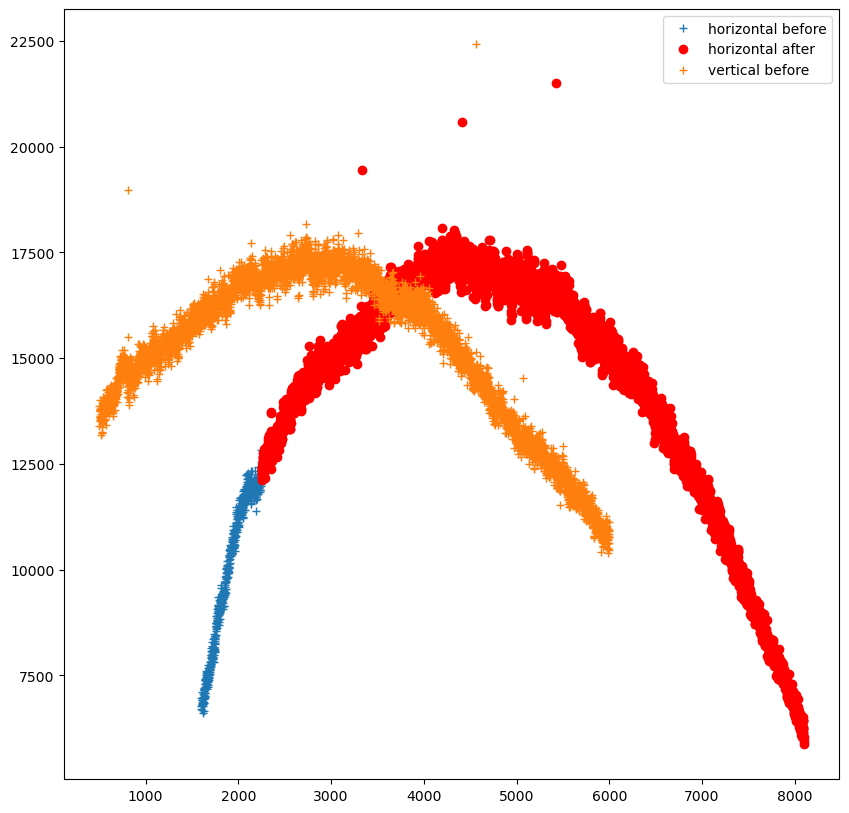

In [38]:
plt.figure(figsize=(10, 10), num="before and after changing range")

xaxis = data_dict['horizontal_profile.txt']['xaxis']
yaxis = data_dict['horizontal_profile.txt']['profile']
plt.plot(xaxis, yaxis, '+', label='horizontal before')
plt.plot(new_horizontal_xaxis, new_horizontal_yaxis, 'or', label='horizontal after')

xaxis = data_dict['vertical_profile.txt']['xaxis']
yaxis = data_dict['vertical_profile.txt']['profile']
plt.plot(xaxis, yaxis, '+', label='vertical before')

plt.legend()

## replacing range 

In [39]:
data_dict['horizontal_profile.txt']['xaxis'] = new_horizontal_xaxis
data_dict['horizontal_profile.txt']['profile'] = new_horizontal_yaxis

data_dict['vertical_profile.txt']['xaxis'] = new_vertical_xaxis
data_data['vertical_profile.txt']['yaxis'] = new_vertical_yaxis

# fitting horizontal and vertical profile

### gaussian 

In [65]:
estimated_center = {'horizontal_profile.txt': 4456,    # 4456
                    'vertical_profile.txt': 2912}

In [66]:
mod = lmfit.models.GaussianModel() + lmfit.models.ConstantModel()

profile_fitted_dict_gaussian = {}
for _key in data_dict.keys():
    # _key being the profile file name
    
    xaxis = data_dict[_key]['xaxis']
    profile_dict = {}
    yaxis = data_dict[_key]['profile']

    pars = mod.make_params(c=yaxis.mean(),
                           center=estimated_center[_key],
                           sigma=xaxis.std(),
                           amplitude=xaxis.std() * yaxis.ptp())
    out = mod.fit(yaxis, pars, x=xaxis)                   
                           
    profile_fitted_dict_gaussian[_key] = {'center_value': round(out.params['center'].value),
                                          'fitting': out.best_fit,
                                         }



### polynomial 

In [67]:
def poly3d(x, a, b, c, d):
    return a + b*x + c*x**2 + d*x**3 

In [68]:
model = lmfit.models.PolynomialModel(3)

In [69]:
profile_fitted_dict_poly = {}
for _key in data_dict.keys():
    # _key being the profile file name
    
    xaxis = data_dict[_key]['xaxis']
    profile_dict = {}
    yaxis = data_dict[_key]['profile']

    par = model.guess(yaxis, x=xaxis)
    out = model.fit(yaxis, par, x=xaxis)                   
                           
    parameter = list([par['c0'].value, par['c1'].value, par['c2'].value, par['c3'].value])
    
    fm = lambda x: -poly3d(x, *parameter)
    r = minimize_scalar(fm, bounds=(1000, 6000))
    x_max = r['x']
    y_max = poly3d(r['x'], *parameter)
                          
    profile_fitted_dict_poly[_key] = {'center_value': round(x_max),
                                 'fitting': out.best_fit,
                                 'parameters': parameter,
                                }


## display 

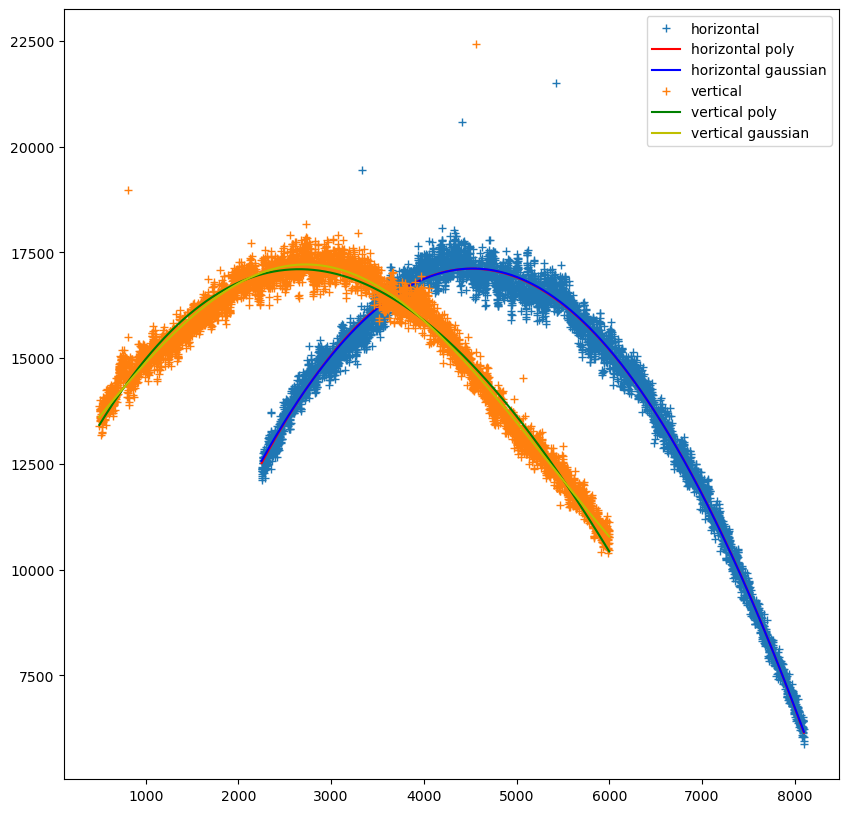

In [81]:
plt.figure(figsize=(10, 10), num="fittings")

xaxis = data_dict['horizontal_profile.txt']['xaxis']
yaxis_fitted = profile_fitted_dict_poly['horizontal_profile.txt']['fitting']
yaxis_gaussian_fitted = profile_fitted_dict_gaussian['horizontal_profile.txt']['fitting']
yaxis = data_dict['horizontal_profile.txt']['profile']

plt.plot(xaxis, yaxis, '+', label='horizontal')
plt.plot(xaxis, yaxis_fitted, 'r', label='horizontal poly')
plt.plot(xaxis, yaxis_gaussian_fitted, 'b', label='horizontal gaussian')

xaxis = data_dict['vertical_profile.txt']['xaxis']
yaxis_fitted = profile_fitted_dict_poly['vertical_profile.txt']['fitting']
yaxis_gaussian_fitted = profile_fitted_dict_gaussian['vertical_profile.txt']['fitting']
yaxis = data_dict['vertical_profile.txt']['profile']

plt.plot(xaxis, yaxis, '+', label='vertical')
plt.plot(xaxis, yaxis_fitted, 'g', label='vertical poly')
plt.plot(xaxis, yaxis_gaussian_fitted, 'y', label='vertical gaussian')

plt.legend()

In [47]:
# profile_fitted_dict

## Let's plot the center of the beam found over the image 

In [48]:
base_folder = top_folder + "/median_data/"
image_filename = os.path.join(base_folder, '300deg_nbr1_30s_frames_OB.tif')
assert os.path.exists(image_filename)

In [49]:
image = np.asarray(Image.open(image_filename))

center_x = profile_fitted_dict['horizontal_profile.txt']['center_value']
center_y = profile_fitted_dict['vertical_profile.txt']['center_value']



Text(4544, 2686, '   x: 4514\n   y: 2656')

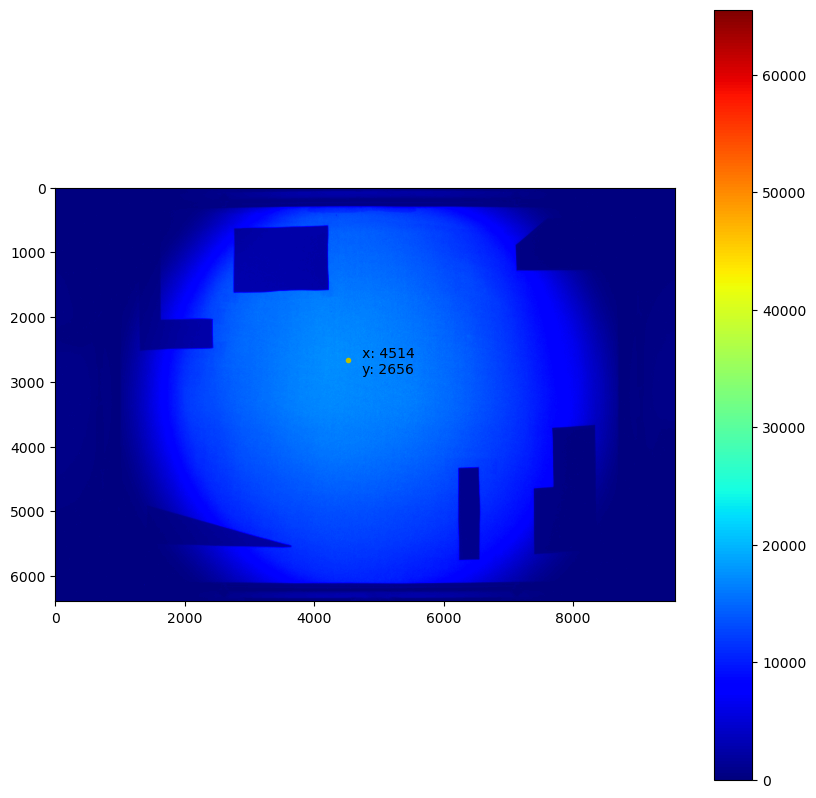

In [50]:
text_offset = 30

plt.figure(num='center', figsize=(10, 10))
plt.imshow(image, cmap='jet')
plt.plot(center_x, center_y, '.y')
plt.colorbar()
plt.text(center_x+text_offset, center_y+text_offset,
         f"   x: {center_x}\n   y: {center_y}",
                 horizontalalignment='left',
         verticalalignment='center'
)


## Evaluation of fitting 

In [51]:
sum_diff_dict = {}
for _key in data_dict.keys():
    xaxis = data_dict[_key]['xaxis']
    yaxis = data_dict[_key]['profile']
    yaxis_fitted = poly3d(data_dict[_key]['xaxis'], *profile_fitted_dict[_key]['parameters'])
    
    sum_diff = 0
    for _y, _y_fitted in zip(yaxis, yaxis_fitted):
        sum_diff += abs(_y - _y_fitted)
    
    sum_diff_dict[_key] = np.mean(sum_diff)

In [52]:
print(sum_diff_dict)

{'horizontal_profile.txt': 1210897.9180834414, 'vertical_profile.txt': 1323663.152220952}
